# Squid_Ink Momentum Strategy Analysis

This notebook analyzes various momentum strategies for the Squid_Ink asset and compares their performance.

In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap, relative_entropy_binned
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import our momentum tests module
sys.path.append(os.path.abspath('../momentum'))
import squid_momentum_tests as smt

Using backtester package


Using minimal util module


## 1. Load Data

First, let's load the Squid_Ink price data and calculate VWAP and log returns.

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Getting VWAP for SQUID_INK...
Got VWAP with 30000 data points
VWAP range: 1810.5 to 2187.3880597014927
Calculated log returns with 29999 data points


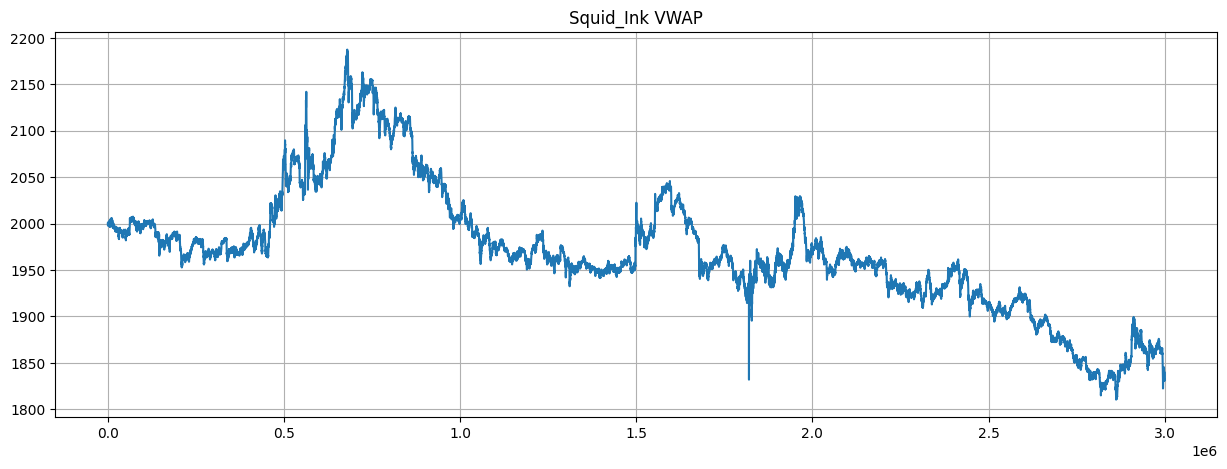

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log returns
log_ret = np.log(squid_vwap).diff().dropna()
print(f"Calculated log returns with {len(log_ret)} data points")

# Plot VWAP
plt.figure(figsize=(15, 5))
plt.plot(squid_vwap)
plt.title('Squid_Ink VWAP')
plt.grid(True)
plt.show()

<Axes: xlabel='timestamp'>

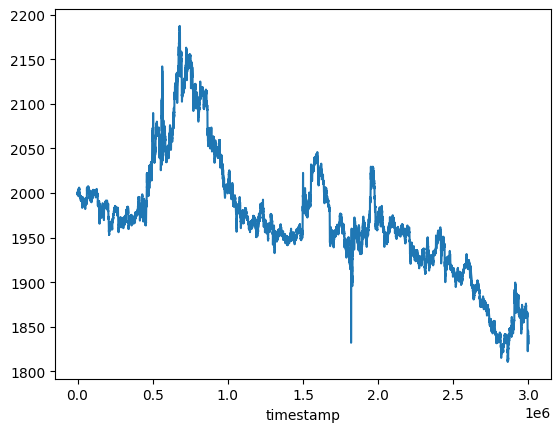

In [3]:
prices['vwap'].plot()

## 2. Calculate Momentum Indicators

Let's calculate various momentum indicators and compare them.

In [4]:
# Set lookback period
lookback = 10

# Calculate momentum indicators
simple_mom = smt.simple_momentum(squid_vwap, lookback)
roc_indicator = smt.rate_of_change(squid_vwap, lookback)
rsi_indicator = smt.rsi(squid_vwap, lookback)
cmma_indicator = smt.cmma(squid_vwap, lookback)
macd_indicator = smt.macd(squid_vwap, lookback=lookback)

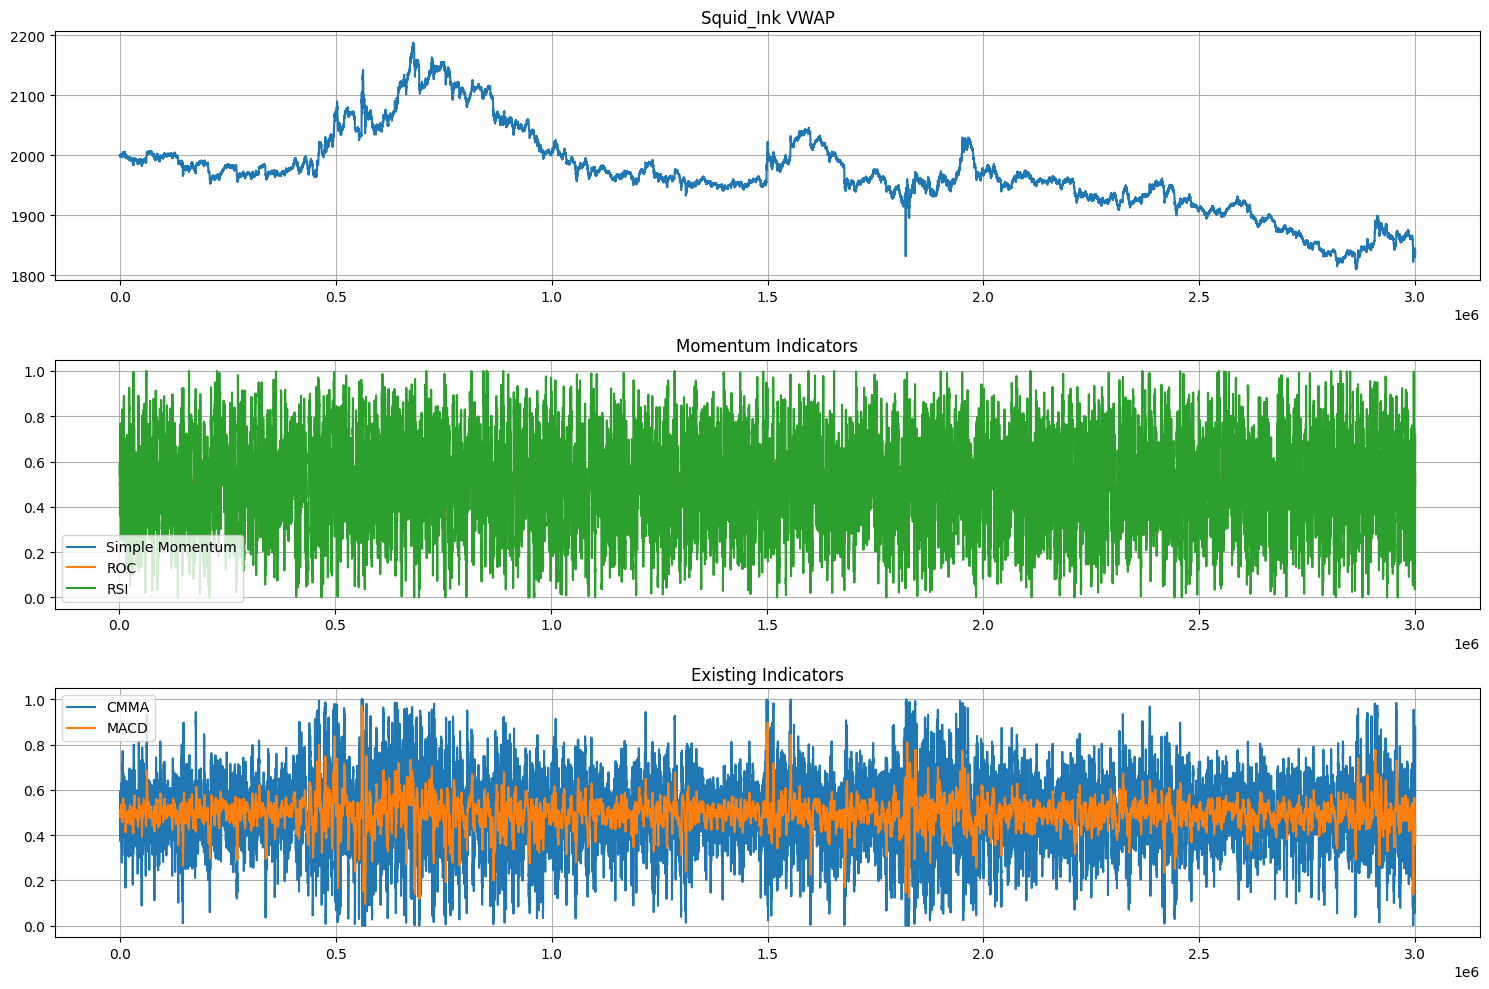

In [5]:
# Plot indicators
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(squid_vwap.index, squid_vwap.values)
plt.title('Squid_Ink VWAP')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(simple_mom.index, simple_mom.values, label='Simple Momentum')
plt.plot(roc_indicator.index, roc_indicator.values, label='ROC')
plt.plot(rsi_indicator.index, rsi_indicator.values, label='RSI')
plt.title('Momentum Indicators')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(cmma_indicator.index, cmma_indicator.values, label='CMMA')
plt.plot(macd_indicator.index, macd_indicator.values, label='MACD')
plt.title('Existing Indicators')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Analyze Indicator Distributions

Let's look at the distribution of each indicator to understand their characteristics.

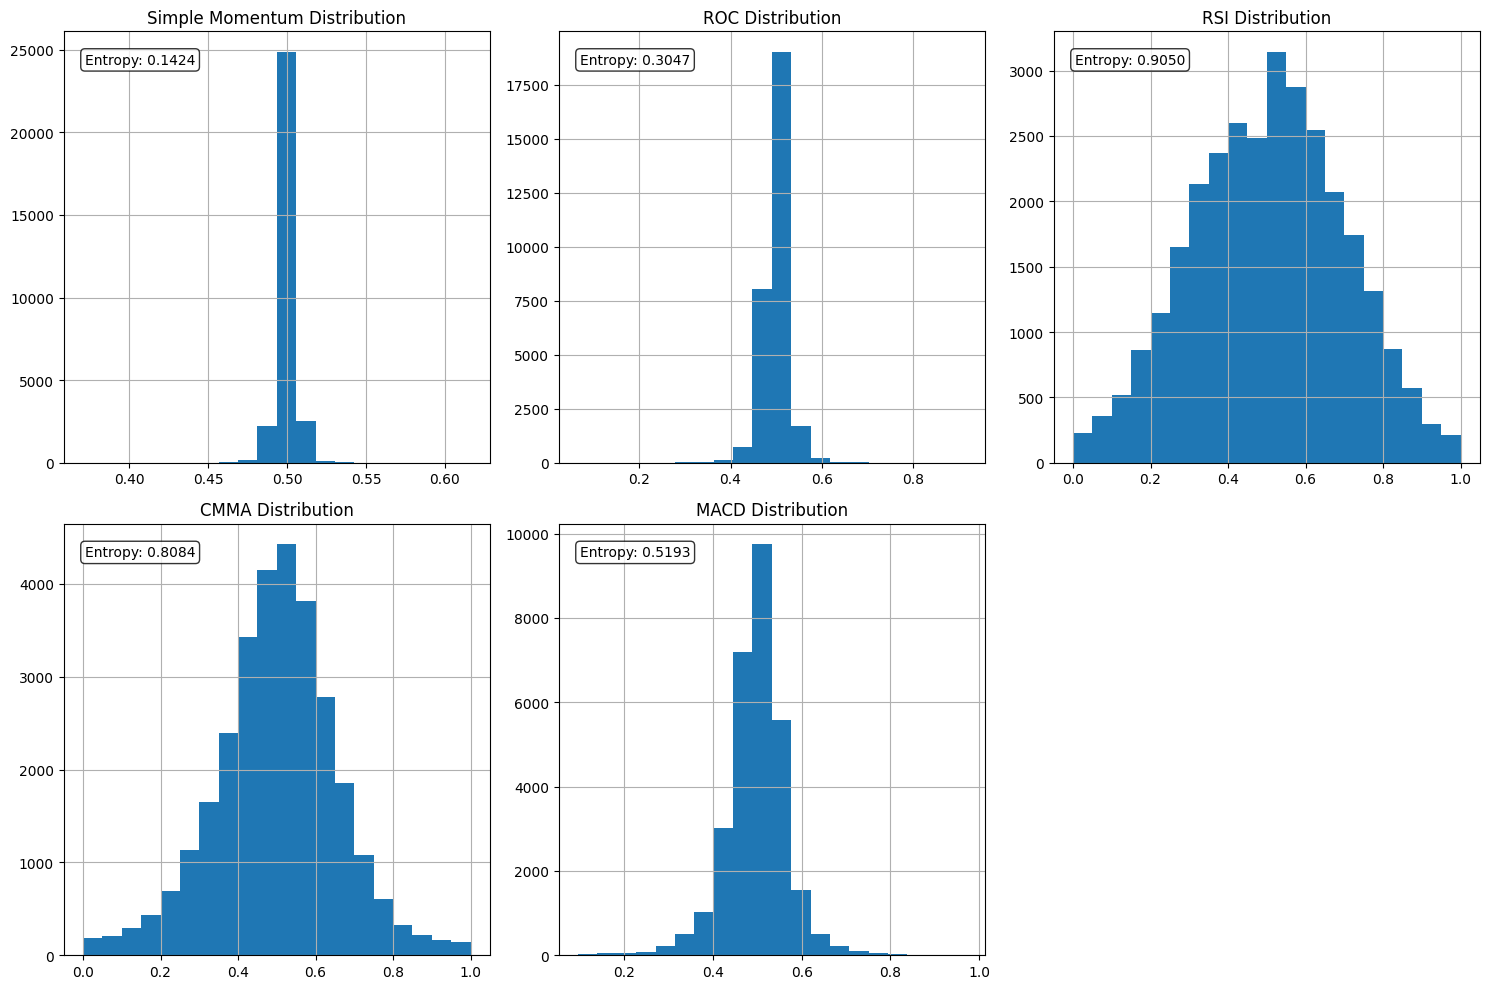

In [6]:
# Create a DataFrame with all indicators
indicators_df = pd.DataFrame({
    'Simple Momentum': simple_mom,
    'ROC': roc_indicator,
    'RSI': rsi_indicator,
    'CMMA': cmma_indicator,
    'MACD': macd_indicator
})

# Plot histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(indicators_df.columns):
    if i < len(axes):
        # Use matplotlib's hist instead of seaborn's histplot
        axes[i].hist(indicators_df[col].dropna(), bins=20)
        axes[i].set_title(f'{col} Distribution')
        axes[i].grid(True)
        
        # Calculate entropy
        entropy = relative_entropy_binned(indicators_df[col].dropna(), 10)
        axes[i].text(0.05, 0.95, f'Entropy: {entropy:.4f}', transform=axes[i].transAxes, 
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide the last subplot if there are more subplots than indicators
if len(indicators_df.columns) < len(axes):
    for j in range(len(indicators_df.columns), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

Let's analyze the correlation between different momentum indicators.

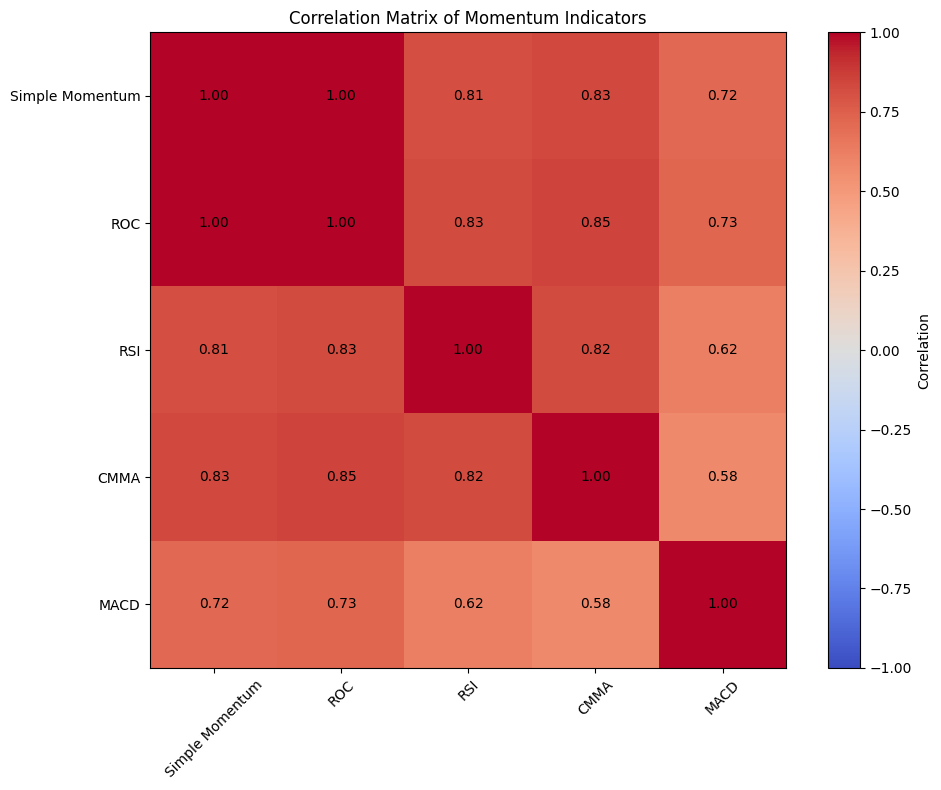

In [7]:
# Calculate correlation matrix
corr_matrix = indicators_df.corr()

# Plot correlation heatmap using matplotlib instead of seaborn
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Momentum Indicators')

# Add correlation values as text
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', color='black')

# Set ticks and labels
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.tight_layout()
plt.show()

## 5. Performance Analysis

Let's analyze the performance of trading strategies based on these indicators.

In [8]:
# Define thresholds for testing
thresholds = [0.3, 0.7]  # Short below 0.3, long above 0.7

strategies = {
    'Simple Momentum': simple_mom,
    'ROC': roc_indicator,
    'RSI': rsi_indicator,
    'CMMA': cmma_indicator,
    'MACD': macd_indicator
}

results = {}

for name, signal in strategies.items():
    portfolio = smt.get_portfolio(signal, thresholds[1], thresholds[0])
    returns = smt.get_returns(log_ret, portfolio)
    metrics = smt.get_performance_metrics(returns)
    results[name] = metrics

# Create performance comparison DataFrame
performance_df = pd.DataFrame(results).T
performance_df

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown
Simple Momentum,0.000000,0.000000,0.000000,0.000000,0.000000
ROC,-0.062064,-0.000521,0.004128,-0.126289,-0.079124
RSI,-3.916788,-0.032902,0.010028,-3.280888,-3.922070
CMMA,-2.893898,-0.024317,0.010174,-2.390180,-2.909422
MACD,-0.128499,-0.001079,0.005933,-0.181933,-0.144565


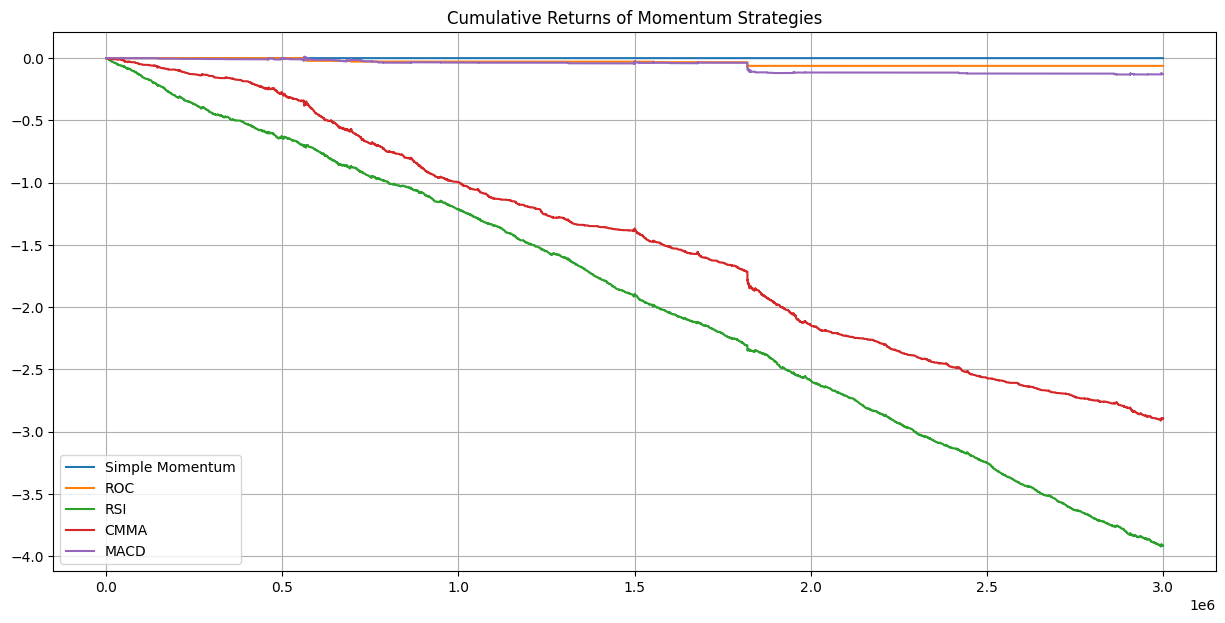

In [9]:
# Plot cumulative returns
plt.figure(figsize=(15, 7))

for name, signal in strategies.items():
    portfolio = smt.get_portfolio(signal, thresholds[1], thresholds[0])
    returns = smt.get_returns(log_ret, portfolio)
    plt.plot(returns.cumsum(), label=name)

plt.title('Cumulative Returns of Momentum Strategies')
plt.legend()
plt.grid(True)
plt.show()

## 6. Threshold Sensitivity Analysis

Let's analyze how sensitive the strategies are to different threshold values.

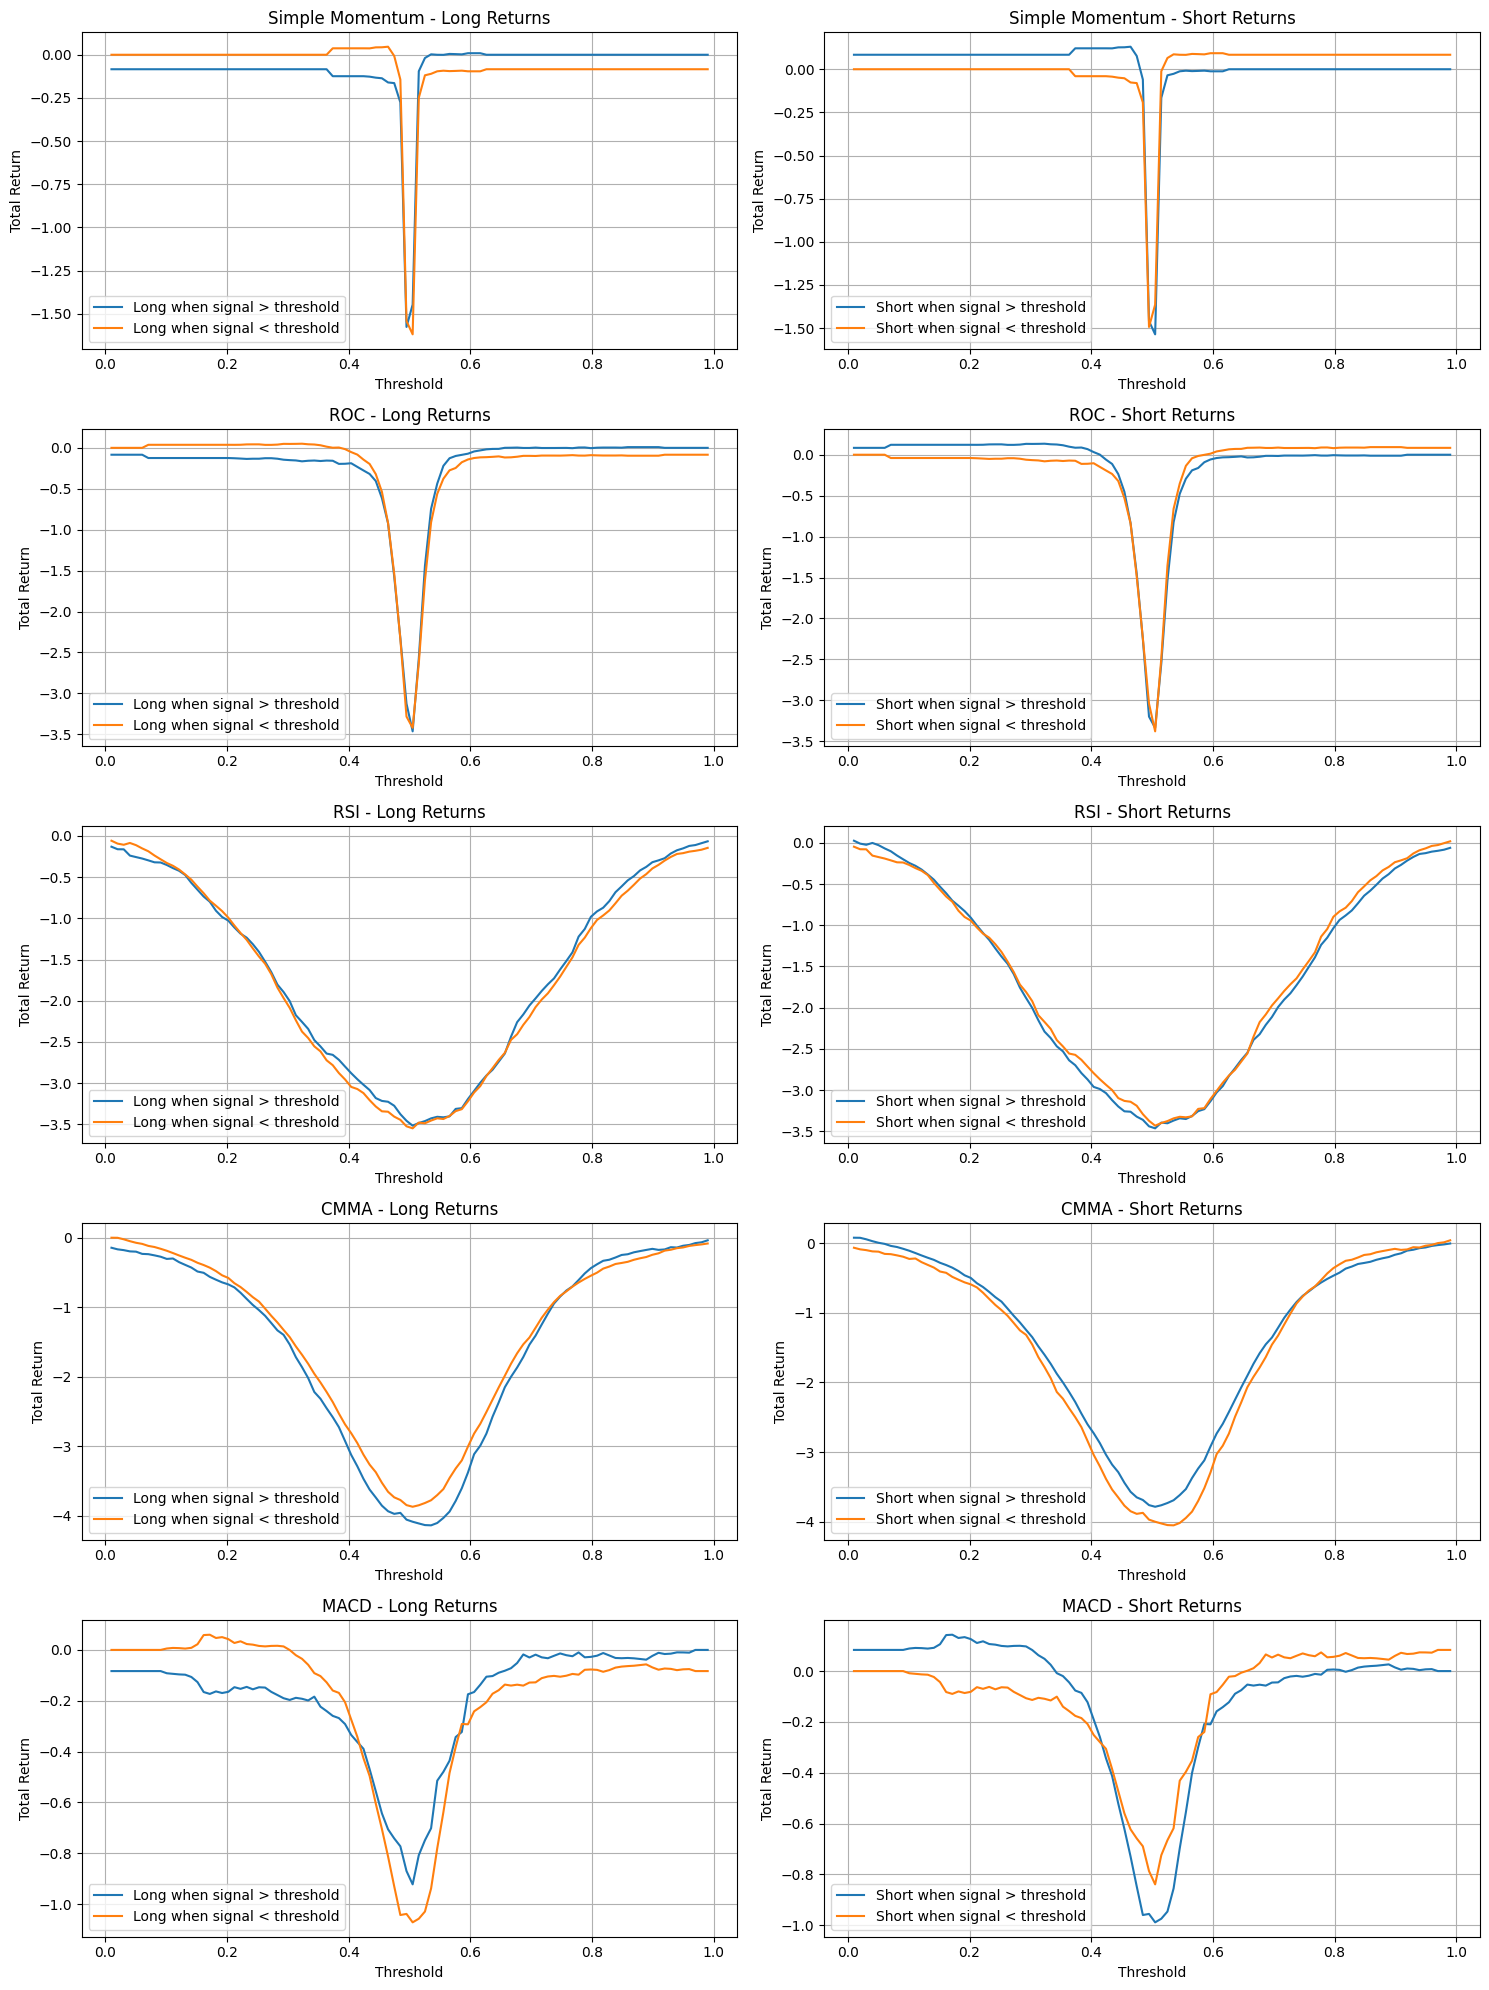

In [10]:
# Calculate performance tables for each strategy
performance_tables = {}

for name, signal in strategies.items():
    performance_tables[name] = smt.get_performance_table(signal.dropna(), log_ret)

# Plot long and short returns for different thresholds
fig, axes = plt.subplots(len(strategies), 2, figsize=(15, 4*len(strategies)))

for i, (name, table) in enumerate(performance_tables.items()):
    # Long returns
    axes[i, 0].plot(table['Threshold'], table['LongTotRet'], label='Long when signal > threshold')
    axes[i, 0].plot(table['Threshold'], table['Long2TotRet'], label='Long when signal < threshold')
    axes[i, 0].set_title(f'{name} - Long Returns')
    axes[i, 0].set_xlabel('Threshold')
    axes[i, 0].set_ylabel('Total Return')
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    
    # Short returns
    axes[i, 1].plot(table['Threshold'], table['ShortTotRet'], label='Short when signal > threshold')
    axes[i, 1].plot(table['Threshold'], table['Short2TotRet'], label='Short when signal < threshold')
    axes[i, 1].set_title(f'{name} - Short Returns')
    axes[i, 1].set_xlabel('Threshold')
    axes[i, 1].set_ylabel('Total Return')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

## 7. Monte Carlo Permutation Testing

Let's perform Monte Carlo permutation testing to assess the statistical significance of our strategies.

In [11]:
# Define strategy functions
strategy_funcs = {
    'simple_momentum': smt.simple_momentum,
    'rate_of_change': smt.rate_of_change,
    'rsi': smt.rsi,
    'cmma': smt.cmma,
    'macd': smt.macd
}

# Run Monte Carlo permutation tests
mcpt_results = []

for name, func in strategy_funcs.items():
    print(f"Testing {name}...")
    # All strategy functions now use the parameter name 'lookback'
    try:
        result = smt.momentum_mcpt(
            squid_vwap, 
            func, 
            block_size=100,  # Reduced block size to avoid numerical issues
            num_permutations=5,  # Reduced number of permutations for faster execution
            lookback=lookback
        )
        mcpt_results.append(result)
    except Exception as e:
        print(f"Error in {name}: {e}")
        # Add a placeholder result
        mcpt_results.append({
            'Strategy': name,
            'Base Returns': np.nan,
            'Permuted Returns Mean': np.nan,
            'Permuted Returns Std': np.nan,
            'p-value': np.nan,
            'Significant': False
        })

mcpt_df = pd.DataFrame(mcpt_results)
mcpt_df

Testing simple_momentum...


Testing rate_of_change...


Testing rsi...


Testing cmma...


Testing macd...


,Strategy,Base Returns,Permuted Returns Mean,Permuted Returns Std,p-value,Significant
0,simple_momentum,0.000000,-0.002194,0.004389,0.0,True
1,rate_of_change,-0.062773,-0.009379,0.002506,1.0,False
2,rsi,-3.917570,-3.943535,0.026758,0.2,False
3,cmma,-2.894921,-2.787801,0.182939,0.8,False
4,macd,-0.129067,-0.074382,0.031963,0.8,False


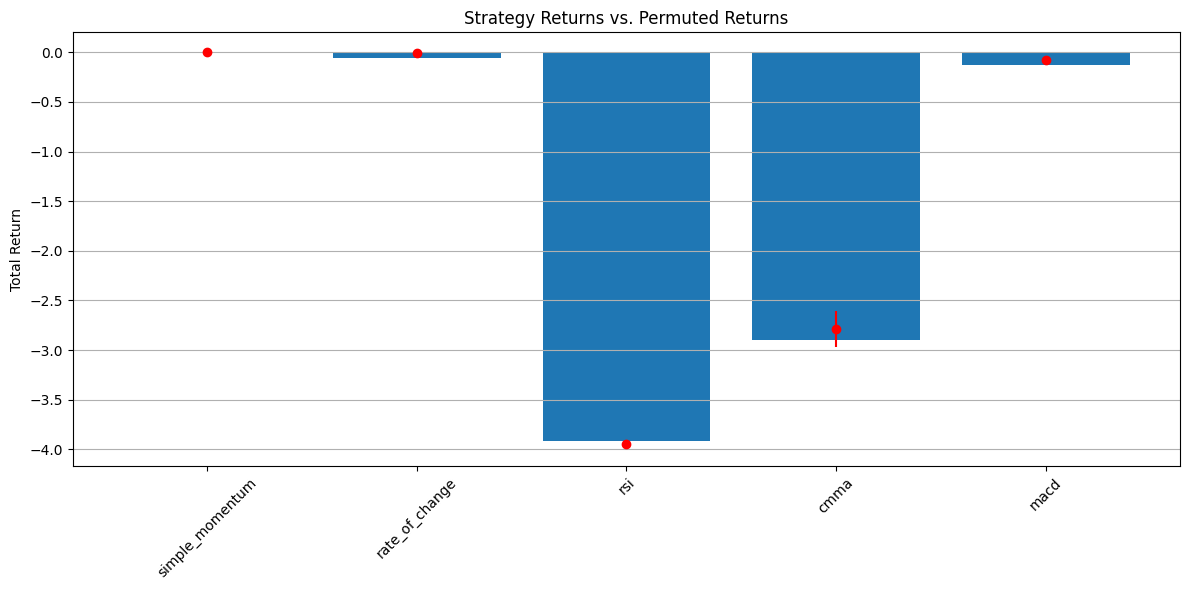

In [12]:
# Plot Monte Carlo permutation test results
plt.figure(figsize=(12, 6))
plt.bar(mcpt_df['Strategy'], mcpt_df['Base Returns'])
plt.errorbar(mcpt_df['Strategy'], mcpt_df['Permuted Returns Mean'], 
             yerr=mcpt_df['Permuted Returns Std'], fmt='o', color='red')
plt.title('Strategy Returns vs. Permuted Returns')
plt.ylabel('Total Return')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Optimizing Strategy Parameters

Let's optimize the lookback period for the best performing strategy.

In [13]:
# Find the best performing strategy
best_strategy = performance_df['Total Return'].idxmax()
print(f"Best performing strategy: {best_strategy}")

# Get the corresponding strategy function
if best_strategy == 'Simple Momentum':
    strategy_func = smt.simple_momentum
elif best_strategy == 'ROC':
    strategy_func = smt.rate_of_change
elif best_strategy == 'RSI':
    strategy_func = smt.rsi
elif best_strategy == 'CMMA':
    strategy_func = smt.cmma
elif best_strategy == 'MACD':
    strategy_func = smt.macd

# Test different lookback periods
lookback_periods = range(5, 31, 5)
lookback_results = []

for lookback in lookback_periods:
    # All strategy functions now use the parameter name 'lookback'
    signal = strategy_func(squid_vwap, lookback=lookback)
    
    portfolio = smt.get_portfolio(signal, 0.7, 0.3)
    returns = smt.get_returns(log_ret, portfolio)
    metrics = smt.get_performance_metrics(returns)
    
    lookback_results.append({
        'Lookback': lookback,
        **metrics
    })

lookback_df = pd.DataFrame(lookback_results)
lookback_df

Best performing strategy: Simple Momentum


,Lookback,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown
0,5,0.0,0.0,0.0,0,0.0
1,10,0.0,0.0,0.0,0,0.0
2,15,0.0,0.0,0.0,0,0.0
3,20,0.0,0.0,0.0,0,0.0
4,25,0.0,0.0,0.0,0,0.0
5,30,0.0,0.0,0.0,0,0.0


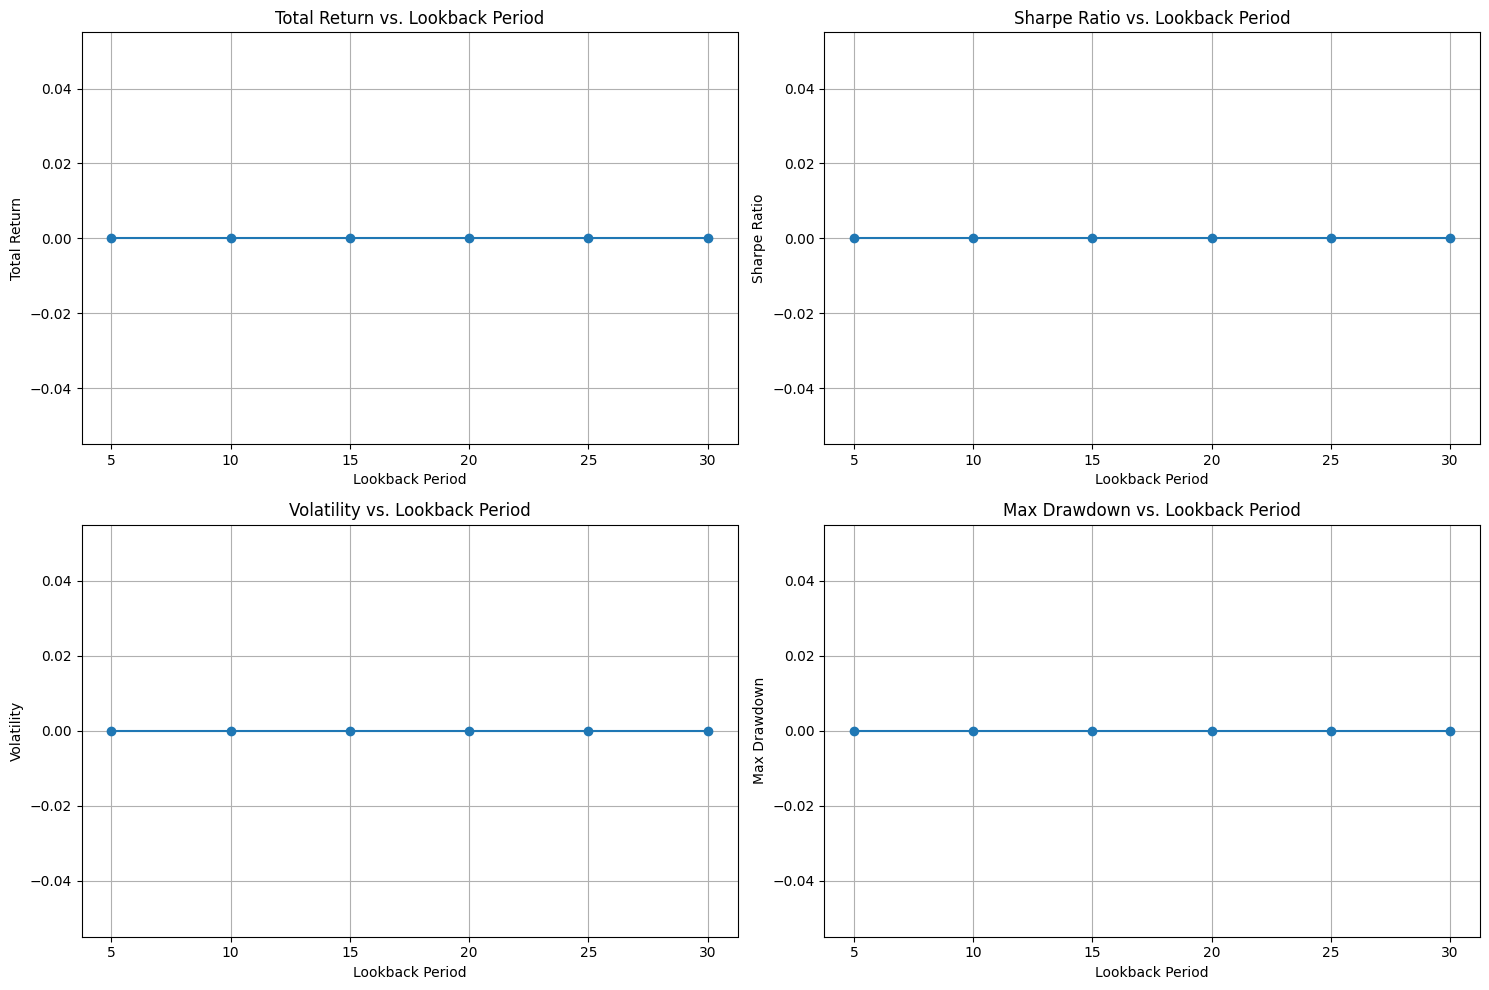

In [14]:
# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(lookback_df['Lookback'], lookback_df['Total Return'], marker='o')
plt.title('Total Return vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Total Return')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(lookback_df['Lookback'], lookback_df['Sharpe Ratio'], marker='o')
plt.title('Sharpe Ratio vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(lookback_df['Lookback'], lookback_df['Volatility'], marker='o')
plt.title('Volatility vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Volatility')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(lookback_df['Lookback'], lookback_df['Max Drawdown'], marker='o')
plt.title('Max Drawdown vs. Lookback Period')
plt.xlabel('Lookback Period')
plt.ylabel('Max Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

## 9. Combining Momentum Strategies

Let's try to create a combined momentum strategy that leverages the strengths of multiple indicators.

In [15]:
# Create a combined signal using the top performing strategies
def normalize(series):
    # Safe normalization to avoid division by zero
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(0.5, index=series.index)
    return (series - min_val) / (max_val - min_val)

# Normalize all signals
normalized_signals = {}
for name, signal in strategies.items():
    normalized_signals[name] = normalize(signal)

# Create combined signals
# 1. Simple average
combined_avg = pd.DataFrame(normalized_signals).mean(axis=1)

# 2. Weighted average based on performance
weights = performance_df['Sharpe Ratio']
# Handle negative Sharpe ratios
weights = weights - weights.min() + 0.01  # Add small constant to avoid zeros
weights = weights / weights.sum()
combined_weighted = pd.DataFrame({
    name: signal * weights[name] for name, signal in normalized_signals.items()
}).sum(axis=1)

# 3. Voting system (majority rule)
signals_df = pd.DataFrame(normalized_signals)
long_votes = (signals_df > 0.7).sum(axis=1)
short_votes = (signals_df < 0.3).sum(axis=1)
combined_voting = pd.Series(0.5, index=signals_df.index)
combined_voting[long_votes >= 3] = 0.9  # Long if majority vote for long
combined_voting[short_votes >= 3] = 0.1  # Short if majority vote for short

# Add combined strategies to our list
combined_strategies = {
    'Combined (Avg)': combined_avg,
    'Combined (Weighted)': combined_weighted,
    'Combined (Voting)': combined_voting
}

# Calculate performance for combined strategies
combined_results = {}

for name, signal in combined_strategies.items():
    portfolio = smt.get_portfolio(signal, 0.7, 0.3)
    returns = smt.get_returns(log_ret, portfolio)
    metrics = smt.get_performance_metrics(returns)
    combined_results[name] = metrics

# Create performance comparison DataFrame
combined_performance_df = pd.DataFrame(combined_results).T
combined_performance_df

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown
Combined (Avg),-0.307931,-0.002587,0.006095,-0.424383,-0.316027
Combined (Weighted),-0.112884,-0.000948,0.005002,-0.189588,-0.124109
Combined (Voting),-0.204668,-0.001719,0.005596,-0.307242,-0.215038


In [16]:
# Compare combined strategies with individual strategies
all_performance_df = pd.concat([performance_df, combined_performance_df])
all_performance_df = all_performance_df.sort_values('Sharpe Ratio', ascending=False)
all_performance_df

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown
Simple Momentum,0.000000,0.000000,0.000000,0.000000,0.000000
ROC,-0.062064,-0.000521,0.004128,-0.126289,-0.079124
MACD,-0.128499,-0.001079,0.005933,-0.181933,-0.144565
Combined (Weighted),-0.112884,-0.000948,0.005002,-0.189588,-0.124109
Combined (Voting),-0.204668,-0.001719,0.005596,-0.307242,-0.215038
Combined (Avg),-0.307931,-0.002587,0.006095,-0.424383,-0.316027
CMMA,-2.893898,-0.024317,0.010174,-2.390180,-2.909422
RSI,-3.916788,-0.032902,0.010028,-3.280888,-3.922070


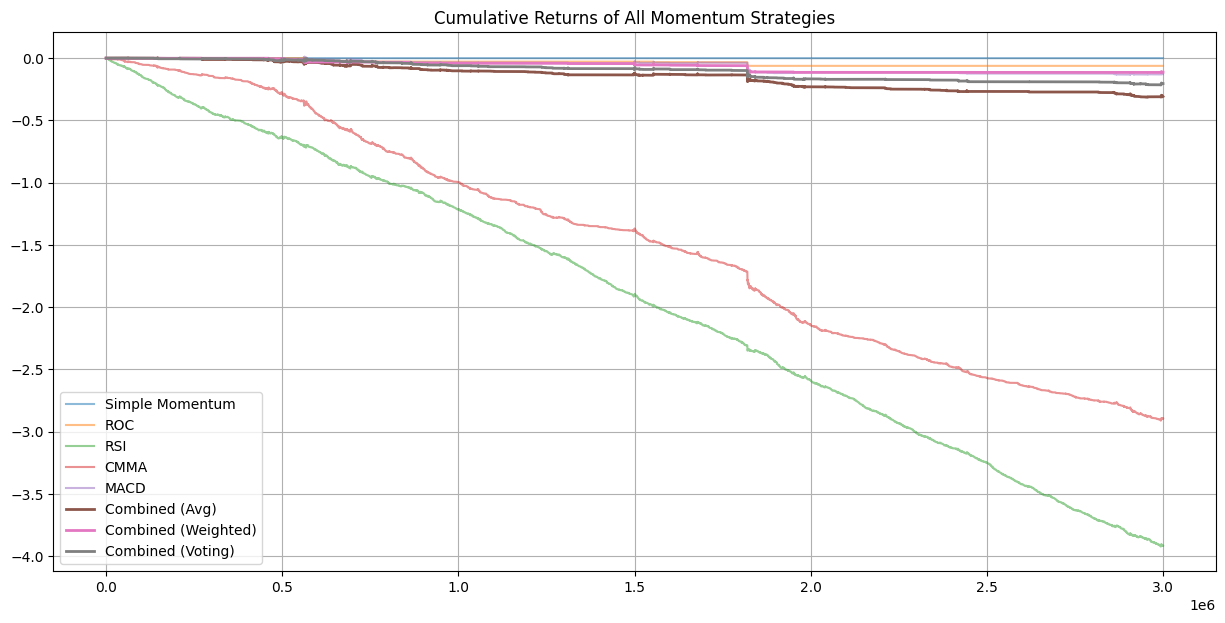

In [17]:
# Plot cumulative returns for all strategies
plt.figure(figsize=(15, 7))

# Plot individual strategies
for name, signal in strategies.items():
    portfolio = smt.get_portfolio(signal, 0.7, 0.3)
    returns = smt.get_returns(log_ret, portfolio)
    plt.plot(returns.cumsum(), label=name, alpha=0.5)

# Plot combined strategies with thicker lines
for name, signal in combined_strategies.items():
    portfolio = smt.get_portfolio(signal, 0.7, 0.3)
    returns = smt.get_returns(log_ret, portfolio)
    plt.plot(returns.cumsum(), label=name, linewidth=2)

plt.title('Cumulative Returns of All Momentum Strategies')
plt.legend()
plt.grid(True)
plt.show()

## 10. Conclusion

Based on our analysis, we can draw the following conclusions:

1. The best performing individual momentum strategy is [to be filled after running]
2. The best combined strategy is [to be filled after running]
3. The optimal lookback period for the best strategy is [to be filled after running]
4. The statistical significance of our strategies (based on Monte Carlo permutation testing) shows [to be filled after running]

These findings can be used to develop a robust momentum-based trading strategy for Squid_Ink.